In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/My \ Drive/NLP/Project/Text_Summarization

/content/drive/My  Drive/NLP/Project/Text_Summarization


In [3]:
#%cd drive/My \ Drive/Text_Summarization

In [4]:
!pwd

/content/drive/My  Drive/NLP/Project/Text_Summarization


In [5]:
!pip install gensim==3.8.0

In [6]:
import gensim
gensim.__version__

'3.8.0'

In [7]:
!pip install pattern

## **Topic Modeling**

In [8]:
debug=False

In [9]:
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_short
from gensim.utils import lemmatize

from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pandas as pd
import pattern

**Load Data:**

In [10]:
df_overview = pd.read_csv("Data/processed/Clean_Lemma_LongForm_Telehealth.csv")
df_overview.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length,Clean_Content_Lemma,Clean_Content_Lemma_LongForm,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\r\n\r\ntelepsychology, meta-analysis...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,36423,veteran face a variety of stressor relate to t...,veteran face a variety of stressor relate to t...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,KEYWORDS:\r\n\r\nremote child custody evaluati...,"Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,The impact of the COVID-19 pandemic on the chi...,72009,the impact of the covid-19 pandemic on the chi...,the impact of the covid-19 pandemic on the chi...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\r\n\r\nforensic e-mental health, tel...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,In November 2019 COVID-19—the infectious highl...,61640,"in November 2019 , covid-19 — the infectious ,...","in November 2019 , covid-19 — the infectious ,...",Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\r\n\r\neducation and training, telep...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,29392,anxiety and depressive disorder be among the m...,anxiety and depressive disorder be among the m...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\r\n\r\nremote psychotherapy, Covid-1...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,In mid-March 2020 the authors—as well as the m...,41383,"in mid - March , 2020 , the author — as well a...","in mid - March , 2020 , the author — as well a...",Covid


In [11]:
# Retrieve an array of cleaned document text corpus
#text_corpus = df_metadata["Clean_Content"].values

text_corpus = df_overview["Clean_Content_Lemma"].values

**Customized gensim preprocess_documents without stemming:**

In [12]:
# Use lemmatize() of Gensim 
def gensim_lemmatize(text):
  lemmatized_out = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(text)]
  return ' '.join(w for w in lemmatized_out)

In [13]:
def preprocess_documents_without_stem(docs):

  #filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, gensim_lemmatize]

  filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short]
  return [preprocess_string(d, filters) for d in docs]

**Function for building a dictionary and preprocess a list or array of document texts:**

In [14]:
def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  #tokenized_texts = preprocess_documents(text_corpus)
  tokenized_texts = preprocess_documents_without_stem(text_corpus)
  
  # Create a dictionary
  dictionary = Dictionary(tokenized_texts)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

  return dictionary, bow_corpus, tokenized_texts

**Function for computing coherence score of a LSI model or LDA model by give number of topics:**

In [15]:
# coherence_type can be 'u_mass' or 'c_v'
# algorithm can be 'LSI' or 'LDA'
def compute_coherence_score(tokenized_texts, bow_corpus, dictionary, num_topics, coherence_type, algorithm):
  if algorithm == 'LSI':
    model = LsiModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 2)

  coherence = CoherenceModel(model=model,
                              corpus=bow_corpus,
                              texts=tokenized_texts,
                              dictionary=dictionary,
                              coherence=coherence_type)
  return coherence.get_coherence()

**Function for generating coherence scores of LSI model or LDA model by given minimum and maximum number of topics.  The coherence scores and the best number of topics are returned:**

In [16]:
def generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm, coherence_type='u_mass'):
  
  coherence_scores=[]
  min_score=0
  max_score=0

  best_num_topics=1

  for k in range(min_topics, max_topics):
    score = compute_coherence_score(tokenized_texts, bow_corpus, dictionary, k, coherence_type, algorithm)
    coherence_scores.append(score)

    if coherence_type == 'u_mass':
      if score < min_score :
        min_score = score
        best_num_topics = k
    else: # coherence_type == 'c_v'
      if score > max_score:
        max_score = score
        best_num_topics= k


  return coherence_scores, best_num_topics

**Function for plotting coherece scores:**

In [17]:
import matplotlib.pyplot as plt
import matplotlib.style as style
#%matplotlib inline

def plot_coherence_scores(min_topics, max_topics, coherence_scores, coherence_type, algorithm, legend=''):
  style.use('fivethirtyeight')

  x = [int(i) for i in range(min_topics, max_topics)]

  plt.figure(figsize=(10,8))
  plt.plot(x, coherence_scores)
  plt.xlabel('Number of topics')
  plt.ylabel('Coherence Value')
  plt.title(legend + ' ' + algorithm + ' Coherence Scores by number of Topics (' + coherence_type + ')')

**Function for printing topics of a LSI model or LDA mode, it also returns that model:**

In [18]:
def print_topics(dictionary, num_topics, algorithm, num_words=10, friendly_print=True):
  
  if algorithm == 'LSI':
    model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)

  if friendly_print:
    # Extract terms from results returned by show_topic()
    for topic_number in range(0, num_topics):
      terms = []
      for term, wt in model.show_topic(topic_number, num_words):
        terms.append(term)
    
      print('Topic ' + str(topic_number) + ':', terms)

  else:
    topics = model.print_topics(num_topics, num_words)
    for topic in topics:
      print(topic)

  return model

## Topic Modeling for entire 44 articles

**Create a dictionary and BOW coprpus:**

In [19]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(text_corpus)

In [20]:
len(tokenized_texts)

44

## Latent Semantic Analysis (LSA) or Latent Semantic Indexing (LSI): Use Singular Value Decomposition (SVD) algorithm to extract hidden topics in corpus.

**Note: We can use perplexity and coherence scores as measures to evaluate the topic model. Typically, lower the perplexity, the better the model. Similarly, the lower the UMass score and the higher the Cv score in coherence, the better the model.**

**Here, we attempt to find the best number of topics by computing and comparing coherence scores of the LSI model:**

In [21]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass, best_num_topics_u_mass = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LSI', coherence_type='u_mass')


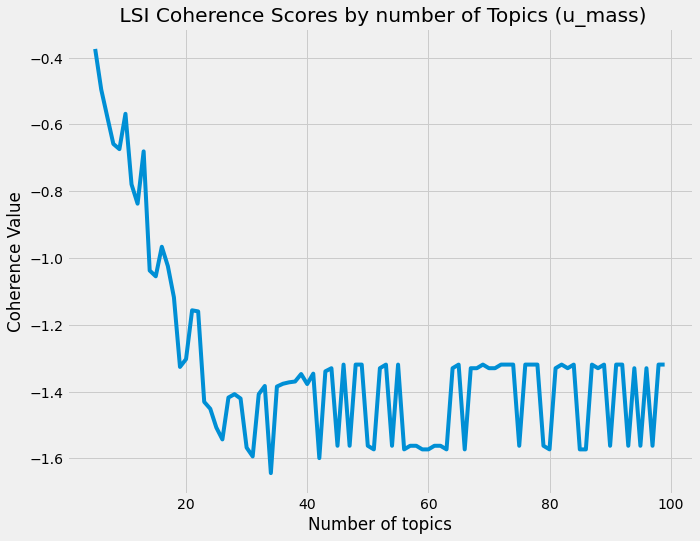

In [22]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass, coherence_type='u_mass', algorithm='LSI')

In [23]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass)

The best number of topics found by u-mass coherence score: 34


It takes long time for calcuating c_v coherence scores, so temporarily disable it. (TODO: Re-enable in final notebook)

In [24]:
# c_v is much slower
#min_topics, max_topics = 5, 100
#coherence_scores_c_v, best_num_topics_c_v = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LSI', coherence_type='c_v')


In [25]:
#plot_coherence_scores(min_topics, max_topics, coherence_scores_c_v, coherence_type='c_v', algorithm='LSI')

In [26]:
#print('The best number of topics found by c-v coherence score:', best_num_topics_c_v)

**Print the topics (based on the best u-mass score):**

In [27]:
lsi_model = print_topics(dictionary, best_num_topics_u_mass, algorithm='LSI', num_words=15, friendly_print=True)

Topic 0: ['health', 'use', 'telepsychology', 'care', 'service', 'mental', 'treatment', 'client', 'provide', 'practice', 'psychologist', 'provider', 'technology', 'patient', 'training']
Topic 1: ['telepsychology', 'health', 'mental', 'care', 'client', 'clinic', 'psychologist', 'training', 'practice', 'trainee', 'telemental', 'provider', 'veteran', 'tmh', 'supervisor']
Topic 2: ['tmh', 'provider', 'health', 'mental', 'hub', 'patient', 'forensic', 'veteran', 'care', 'psychologist', 'attitude', 'evaluator', 'veterans', 'intervention', 'child']
Topic 3: ['clinic', 'health', 'care', 'use', 'child', 'training', 'trainee', 'evaluator', 'study', 'supervisor', 'veteran', 'participant', 'telepsychology', 'service', 'mental']
Topic 4: ['psychologist', 'practice', 'clinic', 'child', 'clinician', 'intervention', 'family', 'trainee', 'base', 'health', 'study', 'treatment', 'deliver', 'session', 'apa']
Topic 5: ['telepsychology', 'client', 'psychologist', 'clinic', 'trainee', 'study', 'treatment', 'ev

In [28]:
print_topics(dictionary, best_num_topics_u_mass, algorithm='LSI', num_words=15, friendly_print=False)

(0, '0.341*"health" + 0.260*"use" + 0.214*"telepsychology" + 0.192*"care" + 0.188*"service" + 0.174*"mental" + 0.159*"treatment" + 0.145*"client" + 0.142*"provide" + 0.138*"practice" + 0.124*"psychologist" + 0.121*"provider" + 0.119*"technology" + 0.113*"patient" + 0.109*"training"')
(1, '0.492*"telepsychology" + -0.420*"health" + -0.247*"mental" + -0.220*"care" + 0.219*"client" + 0.215*"clinic" + 0.188*"psychologist" + 0.179*"training" + 0.176*"practice" + 0.151*"trainee" + -0.108*"telemental" + -0.106*"provider" + -0.106*"veteran" + -0.104*"tmh" + 0.100*"supervisor"')
(2, '-0.611*"tmh" + -0.321*"provider" + 0.253*"health" + 0.193*"mental" + -0.191*"hub" + -0.190*"patient" + 0.155*"forensic" + -0.149*"veteran" + -0.114*"care" + -0.108*"psychologist" + -0.099*"attitude" + 0.095*"evaluator" + -0.095*"veterans" + 0.090*"intervention" + 0.089*"child"')
(3, '-0.372*"clinic" + -0.265*"health" + -0.253*"care" + 0.241*"use" + 0.226*"child" + -0.206*"training" + -0.197*"trainee" + 0.170*"evalu

**Print the topics (based on the best c-v score):**

In [29]:
#print_topics(dictionary, best_num_topics_c_v, algorithm='LSI', num_words=15, friendly_print=True)

In [30]:
#print_topics(dictionary, best_num_topics_c_v, algorithm='LSI', num_words=15, friendly_print=False)

## Latent Dirichlet Allocation (LDA)

In [31]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass, best_num_topics_u_mass = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')


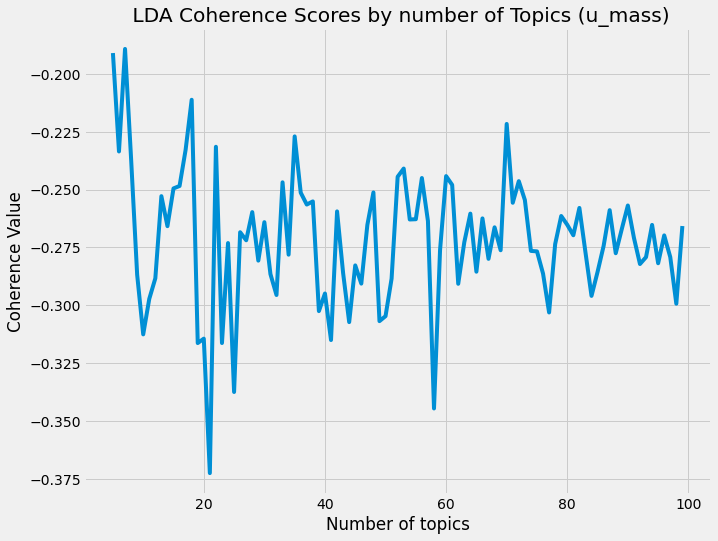

In [32]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass, coherence_type='u_mass', algorithm='LDA')

In [33]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass)

The best number of topics found by u-mass coherence score: 21


In [34]:
lda_model = print_topics(dictionary, best_num_topics_u_mass, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['health', 'care', 'veteran', 'service', 'mental', 'use', 'rural', 'patient', 'community', 'clinic', 'telepsychology', 'treatment', 'need', 'model', 'issue']
Topic 1: ['care', 'health', 'provider', 'tmh', 'use', 'patient', 'video', 'study', 'vha', 'provide', 'telemental', 'mental', 'person', 'treatment', 'veteran']
Topic 2: ['health', 'care', 'use', 'service', 'mental', 'need', 'veteran', 'provider', 'client', 'telepsychology', 'patient', 'practice', 'clinician', 'treatment', 'provide']
Topic 3: ['client', 'participant', 'use', 'work', 'health', 'practice', 'therapist', 'therapy', 'remote', 'provide', 'session', 'pandemic', 'service', 'clinician', 'study']
Topic 4: ['health', 'use', 'child', 'evaluator', 'care', 'patient', 'service', 'telemental', 'datum', 'provide', 'technology', 'person', 'practice', 'study', 'include']
Topic 5: ['health', '2020', 'use', 'client', 'covid', 'administration', 'mental', 'telepsychotherapy', 'online', 'remote', 'study', 'psychological', 'care', 

In [35]:
print_topics(dictionary, best_num_topics_u_mass, algorithm='LDA', num_words=15, friendly_print=False)

(0, '0.014*"telepsychology" + 0.013*"health" + 0.012*"use" + 0.010*"client" + 0.009*"practice" + 0.007*"psychologist" + 0.007*"service" + 0.007*"mental" + 0.006*"training" + 0.006*"treatment" + 0.006*"provide" + 0.006*"intervention" + 0.005*"care" + 0.005*"technology" + 0.005*"participant"')
(1, '0.015*"clinician" + 0.012*"telepsychology" + 0.010*"face" + 0.009*"use" + 0.008*"provider" + 0.008*"family" + 0.007*"record" + 0.006*"intervention" + 0.006*"client" + 0.006*"deliver" + 0.006*"treatment" + 0.005*"health" + 0.005*"child" + 0.005*"study" + 0.005*"need"')
(2, '0.009*"health" + 0.008*"clinic" + 0.007*"treatment" + 0.006*"use" + 0.006*"telepsychology" + 0.006*"service" + 0.006*"care" + 0.005*"client" + 0.005*"mental" + 0.005*"base" + 0.005*"training" + 0.005*"provide" + 0.005*"technology" + 0.004*"study" + 0.004*"include"')
(3, '0.012*"health" + 0.010*"use" + 0.007*"mental" + 0.007*"service" + 0.006*"telepsychology" + 0.006*"psychologist" + 0.006*"treatment" + 0.006*"provide" + 0.00

**LDA model perplexity score**

In [36]:
perplexity = lda_model.log_perplexity(bow_corpus)

print('LDA model Perplexity:', perplexity)

LDA model Perplexity: -8.185570929799484


**Find the dominant topic in each article**

Notes: ldamodel[corpus] invokes __ getitem __(), which returns a list of (int, float) Topic distribution for the given document. Each topic is represented as a pair of its ID and the probability assigned to it.

In [37]:
debug=False

In [38]:
def identify_dominant_topic(ldamodel=lda_model, corpus=bow_corpus, texts=text_corpus):
  
  doc_topics_df = pd.DataFrame()

  for artical_index, topic_dist in enumerate(lda_model[bow_corpus]): 
    
    if(debug):
      print(artical_index, topic_dist)
    
    row = sorted(topic_dist, key=lambda x: (x[1]), reverse=True)
    
    if(debug):
      print(row)

    # Get the Dominant topic, Percentage Contribution and Keywords for each document
    for j, (topic_num, topic_percentage_contribution) in enumerate(row):
      if j == 0:  # => dominant topic
        term_wt = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([term for term, wt in term_wt])
        doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(topic_percentage_contribution,4), topic_keywords]), ignore_index=True)
      else:
        break

  doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    
  return doc_topics_df

In [39]:
df_topic_keywords = identify_dominant_topic(ldamodel=lda_model, corpus=bow_corpus, texts=text_corpus)

df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percentage_Contrib', 'Topic_Keywords', 'Text']


In [40]:
pd.set_option('display.max_colwidth', 100)

In [41]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Percentage_Contrib,Topic_Keywords,Text
0,0,16.0,0.5751,"health, use, telepsychology, treatment, service, psychologist, study, mental, client, care","veteran face a variety of stressor relate to their military service ( Institute of Medicine , 20..."
1,1,4.0,0.9008,"health, use, child, evaluator, care, patient, service, telemental, datum, provide",the impact of the covid-19 pandemic on the child custody evaluation ( CCE ) community have be as...
2,2,13.0,0.8994,"health, mental, service, forensic, telemental, covid, treatment, use, care, research","in November 2019 , covid-19 — the infectious , highly communicable , and potentially fatal disea..."
3,3,8.0,0.5616,"service, tmh, clinic, telepsychology, hub, provide, health, student, psychologist, veteran",anxiety and depressive disorder be among the most common and impair mental illness in the United...
4,4,3.0,0.9997,"client, participant, use, work, health, practice, therapist, therapy, remote, provide","in mid - March , 2020 , the author — as well as the majority of therapist — be advise to work fr..."
5,5,11.0,0.9997,"telepsychology, use, health, training, treatment, study, psychologist, provide, practice, base","in early January of 2020 , chinese health authority notify the World Health Organization ( WHO )..."
6,6,11.0,0.8023,"telepsychology, use, health, training, treatment, study, psychologist, provide, practice, base",million of people with a diagnosable mental disorder within the United States do not have adequa...
7,7,13.0,0.9996,"health, mental, service, forensic, telemental, covid, treatment, use, care, research","the primary focus of covid-19 have be on its impact on physical health . however , the pandemic ..."
8,8,5.0,0.9953,"health, 2020, use, client, covid, administration, mental, telepsychotherapy, online, remote",there be a worldwide gap between the mental health need of child and adolescent and they receive...
9,9,0.0,0.9990,"health, care, veteran, service, mental, use, rural, patient, community, clinic","at the time of write this introduction , covid-19 have infect million and kill hundred of thousa..."


In [42]:
df_dominant_topic.to_csv('./Data/Dominant_Topic_of_Article_LDA.csv')

**Visualize the topics-keywords using pyLDAvis**

**Notes: Colab doesn't support the latest pyLDAvis currently due to conflicts among packages, so installing older version of pyLDAvis seems to be a walk-around solution.**

In [43]:
!pip install pyLDAvis==2.1.2

In [44]:
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()

In [45]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.007139 -0.040941       1        1  16.374071
6     -0.070460  0.007000       2        1  14.540668
19     0.016405 -0.024925       3        1  12.361819
1      0.021270 -0.024355       4        1   6.600164
14     0.001762 -0.002884       5        1   6.080734
13     0.022033  0.001630       6        1   5.771368
0      0.038013  0.046112       7        1   5.252711
17     0.018003 -0.007646       8        1   4.756836
4     -0.001360 -0.005439       9        1   4.436921
5     -0.007167 -0.032681      10        1   3.906885
8     -0.020383  0.009704      11        1   3.732136
3     -0.027177 -0.029648      12        1   3.617283
15     0.056075  0.028922      13        1   2.990513
12    -0.055377  0.057061      14        1   2.972252
16     0.000907 -0.006103      15        1   1.774075
9     -0.000184 -0.006668      16        1   1.756516
20     0.007150 -0.009884      17        1   1.530274
7      0.004578  0.015597      18        1   1.527787
10    -0.004426 -0.001562      19        1   0.013530
2      0.008317  0.020699      20        1   0.001729
18    -0.000840  0.006012      21        1   0.001729, topic_info=                Term         Freq        Total Category  logprob  loglift
220           health  1567.000000  1567.000000  Default  30.0000  30.0000
508              use  1169.000000  1169.000000  Default  29.0000  29.0000
752             care   899.000000   899.000000  Default  28.0000  28.0000
482   telepsychology   968.000000   968.000000  Default  27.0000  27.0000
422          service   901.000000   901.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1825        training     0.006187   520.073240  Topic21  -5.8284  -0.3737
786         clinical     0.005356   407.970711  Topic21  -5.9726  -0.2752
237          include     0.005760   498.726448  Topic21  -5.8999  -0.4033
424          session     0.005137   378.566470  Topic21  -6.0144  -0.2421
58              base     0.005345   490.154580  Topic21  -5.9746  -0.4607

[1589 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
8186      3  0.148970            0001
8186      8  0.446909            0001
8351     11  0.392860             151
5893      1  0.070787             1lt
5893      3  0.637085             1lt
...     ...       ...             ...
543       1  0.459540             –40
3401      2  0.188735             ’re
3401     12  0.377470             ’re
3404     12  0.403651      ”challenge
4694      1  0.640598  ”psychologists

[5918 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 20, 2, 15, 14, 1, 18, 5, 6, 9, 4, 16, 13, 17, 10, 21, 8, 11, 3, 19])

## Non-Negative Matrix Factorization (NMF)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

**Function that use NMF to build topic model and print topics:**

In [47]:
def print_NMF_topics(tokenized_texts, max_df=0.95, min_df=1, number_topics=20, number_words_per_topic=10):
  
  text_list=[]

  for token_array in tokenized_texts:
    text_list.append(" ".join(token_array))  # concat tokens for each document to make compatible format for vectorizer.fit_transform()

  vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
  X = vectorizer.fit_transform(text_list)

  idx_to_word = np.array(vectorizer.get_feature_names())

  # apply NMF
  nmf = NMF(n_components=number_topics, solver="mu")
  W = nmf.fit_transform(X)  # document_topics
  H = nmf.components_       # topic_terms

  for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word [topic.argsort()[-number_words_per_topic:]]])))

**Print topics modeled by NMF for all artices:**

In [48]:
print_NMF_topics(tokenized_texts)

Topic 1: person,participant,training,pandemic,state,service,client,practice,psychologist,telepsychology
Topic 2: service,video,trauma,pandemic,covid,telemental,care,vha,ptsd,veteran
Topic 3: psychologist,site,veterans,staff,service,provider,veteran,nyh,hub,tmh
Topic 4: effect,ptsd,vtc,meta,deliver,rct,ftf,veteran,study,telepsychology
Topic 5: face,bits,module,clinician,couple,online,family,bit,telemental,intervention
Topic 6: director,transition,student,supervision,telepsychology,training,supervisor,telesupervision,clinic,trainee
Topic 7: testing,mmpi,examinee,proctor,remote,wisc,evaluator,forensic,administration,test
Topic 8: immigrant,pcp,integrate,model,disparity,community,brazil,rural,care,latinx
Topic 9: ethical,colleague,guide,book,television,intervention,self,help,patient,borgueta
Topic 10: psychotherapist,cbt,psychological,youth,cvt,pandemic,child,2020,covid,telepsychotherapy
Topic 11: ecbi,score,therapist,eyberg,cgi,comer,posttreatment,child,parent,pcit
Topic 12: datum,practic

## Pre-Covid Topic Modeling 

Note: I only use LSI and NMF to do the topic modeling in this section.  Gensim LDA for some reason throws error.

In [49]:
df_precovid = df_overview[df_overview["Classification"] == "Pre-Covid"]

In [50]:
df_precovid.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length,Clean_Content_Lemma,Clean_Content_Lemma_LongForm,Classification
20,Rehabilitation Psychology,Clinician Perspectives Delivering Telehealth Interventions to Children/Families Impacted by Pedi...,2019,Shari L. Wade; Stacey P. Raj; Emily L. Moscato; Megan E. Narad,Purpose: Technological advances have made the delivery of psychological interventions via web-ba...,"KEYWORDS:\r\n\r\nclinicians, pediatric traumatic brain injury, telepsychology","Wade, S. L., Raj, S. P., Moscato, E. L., & Narad, M. E. (2019). Clinician perspectives deliverin...",IntroductionTraumatic brain injury (TBI) represents the leading cause of death and disability in...,36695,2526,"['clinicians,', 'pediatric', 'traumatic', 'brain', 'injury,', 'telepsychology']",6,Health Psychology & Medicine,29,IntroductionTraumatic brain injury TBI represents the leading cause of death and disability in c...,35766,introductiontraumatic brain injury ( TBI ) represent the lead cause of death and disability in c...,introductiontraumatic brain injury ( TBI ) represent the lead cause of death and disability in c...,Pre-Covid
21,Psychological Services,"Efficacy of Synchronous Telepsychology Interventions for People With Anxiety, Depression, Posttr...",2019,Tracey Varker; Rachel M. Brand; Janine Ward; Sonia Terhaag; Andrea Phelps,Telepsychology holds promise as a treatment delivery method that may increase access to services...,"KEYWORDS:\r\n\r\ntelepsychology, Internet delivered text based, telephone delivered, video-telec...","Varker, T., Brand, R. M., Ward, J., Terhaag, S., & Phelps, A. (2019). Efficacy of synchronous te...",The use of information and communication technologies has emerged as the next big frontier in th...,32051,1382,"['telepsychology,', 'Internet', 'delivered', 'text', 'based,', 'telephone', 'delivered,', 'video...",9,Clinical & Counseling Psychology,83,The use of information and communication technologies has emerged as the next big frontier in th...,30983,the use of information and communication technology have emerge as the next big frontier in the ...,the use of information and communication technology have emerge as the next big frontier in the ...,Pre-Covid
22,Translational Issues in Psychological Science,The Role of Telepsychology Training Clinics in Addressing Health Disparities With Rural Latinx I...,2019,Meredith A. Martyr; D. Martin Kivlighan III; Saba Rasheed Ali,"Hispanic individuals comprise the largest immigrant group in the United States, consisting of 55...","KEYWORDS: immigration, Latinx, health disparities, telepsychology, integrated behavioral health","Martyr, M. A., Kivlighan, D. M. III, & Ali, S. R. (2019). The role of telepsychology training cl...","Health disparities across the nation are on the rise, most notably among Latinx and Hispanic imm...",22867,1749,"['immigration,', 'Latinx,', 'health', 'disparities,', 'telepsychology,', 'integrated', 'behavior...",8,General Psychology,31,Health disparities across the nation are on the rise most notably among Latinx and Hispanic immi...,22095,"health disparitie across the nation be on the rise , most notably among Latinx and hispanic immi...","health disparitie across the nation be on the rise , most notably among Latinx and hispanic immi...",Pre-Covid
23,Clinical Psychology: Science and Practice,Integrating technological advances into clinical training and practice: The future is now!,2018,Jeffrey E. Barnett,NaN,"KEYWORDS:\r\n\r\nboundaries, competence, ethics, technology, telepsychology, training","Barnett, J. E. (2018). Integrating technological advances into clinical training and practice: T...","The use of various technologies, such as videoconferencing, email, text messaging, apps, and soc...",18682,3,"['boundaries,', 'competence,', 'ethics,', 'technology,', 'telepsychology,', 'trai

**Retrieve Pre-Covid text corpus:**

In [51]:
text_corpus_precovid = df_precovid["Clean_Content_Lemma"].values

**Build dictionary, bow, and tokenized texts from Pre-Covid corpus:**

In [52]:
dictionary_precovid, bow_corpus_precovid, tokenized_texts_precovid = build_dictionary_preprocess_corpus(text_corpus_precovid)


**Find the best number of topics for Pre-Covid articles:**

In [53]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass_precovid, best_num_topics_u_mass_precovid = generate_coherence_scores(min_topics, max_topics, tokenized_texts_precovid, bow_corpus_precovid, dictionary_precovid, algorithm='LSI', coherence_type='u_mass')


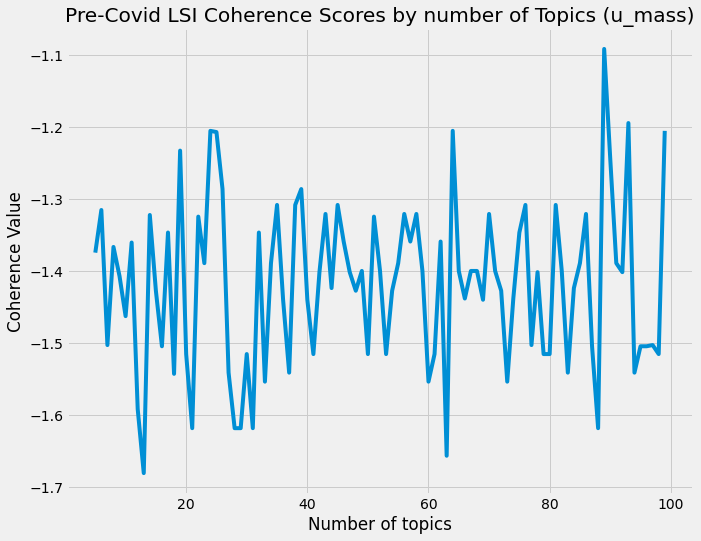

In [54]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_precovid, coherence_type='u_mass', algorithm='LSI', legend='Pre-Covid')


In [55]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_precovid)


The best number of topics found by u-mass coherence score: 13


In [56]:
lsi_model_precovid = print_topics(dictionary_precovid, best_num_topics_u_mass_precovid, algorithm='LSI', num_words=15, friendly_print=True)


Topic 0: ['development', 'negotiate', 'method', 'stress', 'intimate', 'executive', 'motivation', 'team', 'help', 'institutionalized', 'mortality', 'measurestelepsychology', 'helpful', 'fqhc', 'facilitator']
Topic 1: ['method', 'development', 'executive', 'technical', 'stress', 'team', 'mortality', 'intend', 'institutionalized', 'avail', 'merit', 'straightforward', 'judgment', 'oberjohn', 'motivation']
Topic 2: ['technical', 'stress', 'negotiate', 'surveyparticipant', 'development', 'intend', 'avail', 'evaluate', 'oberjohn', 'lingely', 'straightforward', 'follow', 'intimate', 'method', 'severity']
Topic 3: ['mortality', 'institutionalized', 'technical', 'surveyparticipant', 'technologically', 'avail', 'context', 'american', 'development', 'reputation', 'executive', 'invariably', 'learn', 'carey', 'motivation']
Topic 4: ['helpful', 'judgment', 'executive', 'fqhc', 'mortality', 'development', 'oberjohn', 'stress', 'technical', 'evaluate', 'preserve', 'avail', 'intend', 'error', 'technolog

**Use NMF topic model to print topics of Pre-Covid articles:**

In [57]:
print_NMF_topics(tokenized_texts_precovid, number_words_per_topic=10)

Topic 1: colleague,book,issue,ethical,guide,intervention,self,borgueta,patient,help
Topic 2: greenwald,governmental,google,program,privacy,nsa,apa,client,psychologist,tmht
Topic 3: depression,farm,support,friend,family,mdi,score,social,subscale,farmer
Topic 4: text,mohr,telepsychology,therapy,rea,high,deliver,vtc,meta,rct
Topic 5: judge,strength,quality,mental,bias,evidence,intervention,deliver,telepsychology,study
Topic 6: content,provider,comer,client,family,bits,intervention,telemental,couple,bit
Topic 7: patient,community,clinic,indian,tribal,shore,aitmh,tow,care,veteran
Topic 8: follow,vtc,condition,comer,base,clinic,child,posttreatment,parent,pcit
Topic 9: community,mental,telepsychology,immigrant,behavioral,integrate,disparity,rural,care,latinx
Topic 10: online,child,deliver,pediatric,tbi,intervention,family,face,telepsychology,clinician
Topic 11: person,supervision,experience,project,vapihcs,tmh,supervisor,rotation,trainee,telesupervision
Topic 12: confidentiality,competency,te

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


## Topic Modeling for articles posted during Covid 

In [58]:
df_covid = df_overview[df_overview["Classification"] == "Covid"]

In [59]:
df_covid.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Clean_Content,Clean_Content_length,Clean_Content_Lemma,Clean_Content_Lemma_LongForm,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veterans: A Meta-Analysis of Services Delivered by Vide...,2021,Michael J. McClellan; Richard Osbaldiston; Rongxiu Wu; Rachael Yeager; Addison D. Monroe; Tyler ...,Veterans face a variety of stressors due to their military service and are more likely to develo...,"KEYWORDS:\r\n\r\ntelepsychology, meta-analysis, veteran, videoconference, phone","McClellan, M. J., Osbaldiston, R., Wu, R., Yeager, R., Monroe, A. D., McQueen, T., & Dunlap, M. ...","Veterans face a variety of stressors related to their military service (Institute of Medicine, 2...",37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran,', 'videoconference,', 'phone']",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related to their military service Institute of Medicine 201...,36423,"veteran face a variety of stressor relate to their military service ( Institute of Medicine , 20...","veteran face a variety of stressor relate to their military service ( Institute of Medicine , 20...",Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remote Child Custody Evaluations (RCCES): The Empirica...,2021,Milfred D. Dale; Desiree Smith,"The COVID-19 pandemic and its requirements for social distancing and limited, if any, in-person ...","KEYWORDS:\r\n\r\nremote child custody evaluations, videoconferencing, telemental health, ethics ...","Dale, M. D., & Smith, D. (2021). Making the case for videoconferencing and remote child custody ...",The impact of the COVID-19 pandemic on the child custody evaluation (CCE) community has been ast...,74025,1577,"['remote', 'child', 'custody', 'evaluations,', 'videoconferencing,', 'telemental', 'health,', 'e...",10,Forensic Psychology,48,The impact of the COVID-19 pandemic on the child custody evaluation CCE community has been astou...,72009,the impact of the covid-19 pandemic on the child custody evaluation ( CCE ) community have be as...,the impact of the covid-19 pandemic on the child custody evaluation ( child custody evaluation )...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Priorities, and Policy Directions",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychology that is relatively underdeveloped considering ...,"KEYWORDS:\r\n\r\nforensic e-mental health, telehealth, telepsychology, forensic evaluation, corr...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Forensic e-mental health: Review, research prioritie...","In November 2019, COVID-19—the infectious, highly communicable, and potentially fatal disease ca...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealth,', 'telepsychology,', 'forensic', 'evaluation,',...",8,Forensic Psychology,128,In November 2019 COVID-19—the infectious highly communicable and potentially fatal disease cause...,61640,"in November 2019 , covid-19 — the infectious , highly communicable , and potentially fatal disea...","in November 2019 , covid-19 — the infectious , highly communicable , and potentially fatal disea...",Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in University Training Clinics: Considerations and Cur...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing numerous challenges resulting from the COVID-19 pand...,"KEYWORDS:\r\n\r\neducation and training, telepsychology, COVID-19, pandemic","Baier, A. L., & Danzo, S. (2021). Moving toward a new era of telepsychology in university traini...",Anxiety and depressive disorders are among the most common and impairing mental illnesses in the...,30147,1650,"['education', 'and', 

**Retrieve text corpus of articles posted during Covid:**

In [60]:
text_corpus_covid = df_covid["Clean_Content_Lemma"].values

**Build dictionary, bow, and tokenized texts from corpus of articles posted during Covid:**

In [61]:
dictionary_covid, bow_corpus_covid, tokenized_texts_covid = build_dictionary_preprocess_corpus(text_corpus_covid)


**Find the best number of topics for articles posted during Covid:**

In [62]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass_covid, best_num_topics_u_mass_covid = generate_coherence_scores(min_topics, max_topics, tokenized_texts_covid, bow_corpus_covid, dictionary_covid, algorithm='LSI', coherence_type='u_mass')


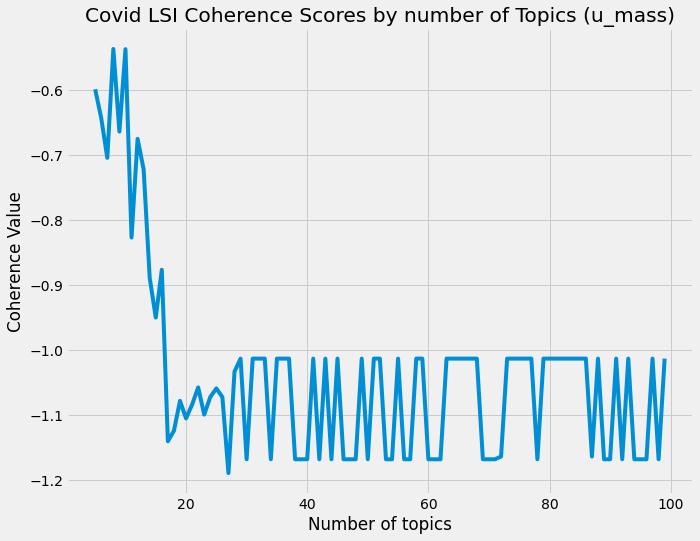

In [63]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass_covid, coherence_type='u_mass', algorithm='LSI', legend='Covid')


In [64]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass_covid)


The best number of topics found by u-mass coherence score: 27


In [65]:
lsi_model_covid = print_topics(dictionary_covid, best_num_topics_u_mass_covid, algorithm='LSI', num_words=15, friendly_print=True)


Topic 0: ['health', 'use', 'telepsychology', 'care', 'service', 'mental', 'treatment', 'client', 'provide', 'practice', 'psychologist', 'technology', 'provider', 'patient', 'training']
Topic 1: ['telepsychology', 'health', 'mental', 'care', 'clinic', 'client', 'psychologist', 'training', 'practice', 'trainee', 'telemental', 'supervisor', 'veteran', 'treatment', 'forensic']
Topic 2: ['clinic', 'care', 'use', 'child', 'health', 'training', 'trainee', 'evaluator', 'study', 'veteran', 'supervisor', 'participant', 'service', 'telepsychology', 'interview']
Topic 3: ['psychologist', 'practice', 'clinic', 'child', 'clinician', 'health', 'trainee', 'intervention', 'base', 'family', 'mental', 'session', 'deliver', 'treatment', 'study']
Topic 4: ['provider', 'forensic', 'mental', 'patient', 'health', 'care', 'psychologist', 'veteran', 'hub', 'evaluator', 'clinic', 'evaluation', 'training', 'research', 'trainee']
Topic 5: ['telepsychology', 'client', 'provider', 'clinic', 'trainee', 'mental', 'stu

The topics of articles during Covid period have more associations with "tele" words.

**Use NMF topic model to print topics of articles posted during Covid:**

In [66]:
print_NMF_topics(tokenized_texts_covid, number_words_per_topic=10)

Topic 1: psychological,telemental,client,youth,pandemic,service,child,2020,covid,telepsychotherapy
Topic 2: participant,trainee,state,concern,supervisor,clinic,client,training,psychologist,telepsychology
Topic 3: site,care,attitude,nyh,veterans,patient,psychologist,provider,hub,tmh
Topic 4: test,evaluation,rcce,cce,forensic,court,custody,interview,child,evaluator
Topic 5: turgoose,meta,videoconferencing,rct,size,effect,telepsychology,ftf,veteran,study
Topic 6: play,child,online,fimp,trainee,participant,training,tutorial,skill,bpt
Topic 7: testing,taker,subtest,mmpi,examinee,proctor,remote,wisc,administration,test
Topic 8: restoration,substance,batastini,correctional,community,research,justice,evaluation,evaluator,forensic
Topic 9: supervisor,telephone,pandemic,vvc,clinic,virtual,video,telemental,care,vha
Topic 10: educational,licensure,service,telepractice,state,interstate,profession,compact,professional,tbh
Topic 11: service,storage,datum,keeping,custodian,unexpected,client,departure,

Reference Notes:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

"Text Analytics with Python_ A Practitioner's Guide to Natural Language Processing, 2nd ed"